In [1]:
from maskgen.utils.model_utils import get_pred_model
from fastshap import ImageSurrogate
from accelerate import Accelerator 
from maskgen.baselines.unet import UNet
from fastshap import FastSHAP
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer2d, KLDivLoss, DatasetInputOnly


accelerator = Accelerator()
device = accelerator.device

config = {
    'pretrained_name': 'google/vit-base-patch16-224',
    "results_path": "/scratch365/dpan/new_results/fastshap_imagenet",
    "csv_path": "./new_results/fastshap_imagenet",
}


In [5]:
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Normalize, Resize
from transformers import ViTImageProcessor

def create_transforms(processor: ViTImageProcessor):
    """Create image transforms based on processor config."""
    normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
    
    if "height" in processor.size:
        size = (processor.size["height"], processor.size["width"])
        crop_size = size
    elif "shortest_edge" in processor.size:
        size = processor.size["shortest_edge"]
        crop_size = (size, size)
    
    return Compose([
        # RandomResizedCrop(crop_size),
        # RandomHorizontalFlip(),
        Resize(crop_size),
        ToTensor(),
        normalize,
    ])

def get_preprocess(processor):
    """Apply transforms across a batch."""
    transforms = create_transforms(processor)
    def preprocess(example_batch):
        example_batch["pixel_values"] = [
            transforms(image.convert("RGB")) 
            for image in example_batch["image"]
        ]
        # keep only pixel_values from dictionary
        example_batch = {key: example_batch[key] for key in ["pixel_values"]}
        return example_batch
    return preprocess

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [6]:
# Load Model
pretrained_name = config['pretrained_name']
processor, target_model = get_pred_model(pretrained_name, device)
vit_config = target_model.config



In [7]:
pred_model = lambda x: target_model(x[0] * x[1]).logits

In [8]:
import torch
import torch.nn as nn

class CustomUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CustomUNet, self).__init__()
        # Encoder: Downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 224 -> 112
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 112 -> 56
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 56 -> 28
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # 28 -> 14
        )

        # Decoder: Adjust dimensions to 14x14
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, out_channels, kernel_size=1)  # Output directly at 14×14
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
imputer = ImageSurrogate(pred_model, width=224, height=224, superpixel_size=16)
explainer = CustomUNet(in_channels=3, out_channels=1000).to(device)
explainer=torch.load("checkpoints/fastshap_explainer.pt").to(device)

/tmp/1097736.1.gpu/ipykernel_587857/2805588907.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  explainer=torch.load("checkpoints/fastshap_explainer.pt").to(device)


In [37]:
from maskgen.utils.image_utils import get_image_example
from maskgen.utils.model_utils import get_pred_model

processor, target_model = get_pred_model(pretrained_name, device)
image = get_image_example(0)
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values.to(device)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = target_model(img).logits.argmax(-1).item()
    secondary_class_idx = target_model(img).logits.argsort(descending=True)[0][1].item()

label = predicted_class_idx
# label = secondary_class_idx
label = torch.tensor([label]).to(device)
print("Predicted class:", target_model.config.id2label[predicted_class_idx])

Predicted class: Egyptian cat


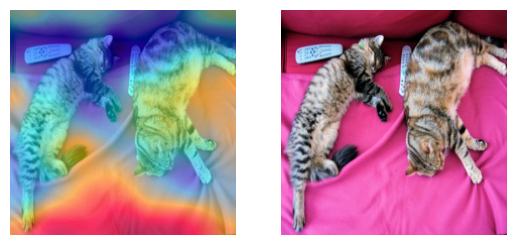

In [38]:
import torch.nn.functional as F
from maskgen.utils.img_utils import plot_overlap_np


def get_heatmap(attribution_attvis):
    # heatmap = torch.relu(attribution_ig.sum(dim=1))
    heatmap = attribution_attvis.reshape(1, 14, 14)
    # Average pooling to convert to 14*14 heatmap
    # heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
    heatmap = heatmap.squeeze(0).detach().cpu().numpy()
    return heatmap

img = inputs['pixel_values'].squeeze(0).detach().cpu().numpy().transpose(1,2,0)
# img = unnormalize_and_255_scale(img, mean, std)
input_img = inputs['pixel_values']
# for idx in range(1000):
#     attribution_attvis = attribution_generator.generate_cam_attn(input_img.cuda()).detach()
attribution_map = -explainer(input_img) # [0,predicted_class_idx,:,:].cpu().detach().numpy()
attribution_map = attribution_map[:, :, 1:-1, 1:-1]
attribution_map = F.interpolate(attribution_map, size=(14, 14), mode='bilinear', align_corners=True)
heatmap = attribution_map[0,predicted_class_idx,:,:].cpu().detach().numpy()

img_int, heatmap_img = plot_overlap_np(img, heatmap, processor.image_mean, processor.image_std)

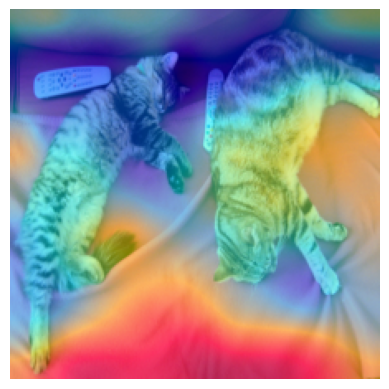

In [39]:
from maskgen.utils.img_utils import plot_overlap
plot_overlap(img_int, heatmap_img)

In [ ]:
from maskgen.utils.img_utils import plot_overlap_np
from maskgen.utils.data_utils import get_imagenet_dataloader

# get dataloader
dataloader = get_imagenet_dataloader(split='tiny', 
                                    batch_size=config['batch_size'], 
                                    processor=processor, 
                                    shuffle=False,
                                    num_samples=config['num_samples'])


In [ ]:
from tqdm import tqdm
import numpy as np

all_inputs = []
all_heatmaps = []

for i, batch in tqdm(enumerate(dataloader), total=len(dataloader), desc="Processing batches"):
    pixel_values = batch['pixel_values'].to(device)
    labels = batch['labels'].to(device)

    attribution_map = explainer(pixel_values) # [0,predicted_class_idx,:,:].cpu().detach().numpy()
    attribution_map = attribution_map[:, :, 1:-1, 1:-1]
    attribution_map = F.interpolate(attribution_map, size=(14, 14), mode='bilinear', align_corners=True)
    heatmap = attribution_map[:,labels,:,:].cpu().detach().numpy()

    inputs_np = pixel_values.cpu().numpy()
    heatmap_np = heatmap
    all_inputs.append(inputs_np)
    all_heatmaps.append(heatmap_np)

all_inputs = np.concatenate(all_inputs, axis=0)
all_heatmaps = np.concatenate(all_heatmaps, axis=0)